In [1]:
import os.path
from operator import itemgetter

import numpy as np
import pandas as pd

import vjp.data as data
import vjp.preprocess as preprocess
import vjp.folds as folds
import vjp.text as text

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

import vjp.preprocess as preprocess
import vjp.models as models

Retrieve a preprocessed dataframe using the pipeline defined by `data_exploration.ipynb`.

In [2]:
# Load from file if exists (e.g. pregenerated via preprocess CLI)
DF_FILENAME = 'connected_components.parquet'
if os.path.exists(DF_FILENAME):
    print(f'Reading from {DF_FILENAME}...')
    df = pd.read_parquet(DF_FILENAME)
else:           # Generate on the go
    print('File not found, generating dataframe...')
    namespace = preprocess.Namespace()
    namespace.connected_component_tags = ('req', 'arg', 'claim', 'mot', 'dec')
    namespace.use_child_text_tag_names = ('mot', 'dec')
    namespace.level = preprocess.PreprocessingLevels.CONNECTED_COMPONENTS
    df = preprocess.preprocess(namespace)

df.head()

File not found, generating dataframe...


,document_index,fact,req,arg,claim,mot,dec,label
0,0,L’Ufficio appellava la citata sentenza,L’Ufficio appellava la citata sentenza La Soci...,in quanto tale decisione avrebbe recepito i mo...,sia perchè l’appello stesso non avrebbe lo sco...,Va inoltre disattesa l’eccezione di inammissib...,La Commissione Tributaria Regionale respinge l...,0
1,0,La Società con memoria costitutiva chiede: - i...,L’Ufficio appellava la citata sentenza La Soci...,in quanto tale decisione avrebbe recepito i mo...,sia perchè l’appello stesso non avrebbe lo sco...,Va inoltre disattesa l’eccezione di inammissib...,La Commissione Tributaria Regionale respinge l...,0
2,1,L’appellante conclude chiedendo: “voglia la Co...,L’appellante conclude chiedendo: “voglia la Co...,deduce che all’epoca dei fatti non sussisteva ...,Si è costituita in giudizio la S.p.a. la quale...,La perplessità che l’Agenzia delle Entrate con...,Respinge l’appello dell’Ufficio e conferma la ...,0
3,2,propone appello per la conferma dell’atto l'Ag...,propone appello per la conferma dell’atto l'Ag...,ribadisce inoltre non pare attendibile la dich...,I primi giudici secondo l’Ufficio non hanno da...,La Commissione ritiene che il potere di dispor...,Conferma la decisione di primo grado.,0
4,3,"Con ricorso in appello a questa C.T.R., l'Uffi...","Con ricorso in appello a questa C.T.R., l'Uffi...",Veniva altresì lamentata la carente motivazion...,"nonché errata, contraddittoria e carente motiv...","Nel merito, il Collegio ritiene di non poter c...",la Commissione Tributaria Regionale del Friuli...,0


In [3]:
# Reproducibility
random_state = 1717

## Splits

All tag types are gathered, so that multiple experiments may be carried out by eventually excluding some of the columns.

Balanced KFold splits are computed at document level using a MIP formulation. 

In [4]:
fold_maps = folds.compute_decision_folds(df, verbose=True, seed=random_state)

Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: May  6 2022 

command line - cbc /tmp/4d8d30fff7fd4f18a8b334621bcc3b49-pulp.mps RandomS 1717 timeMode elapsed branch printingOptions all solution /tmp/4d8d30fff7fd4f18a8b334621bcc3b49-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 235 COLUMNS
At line 5569 RHS
At line 5800 BOUNDS
At line 6852 ENDATA
Problem MODEL has 230 rows, 1051 columns and 3230 elements
Coin0008I MODEL read with 0 errors
randomSeed was changed from 1234567 to 1717
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.4 - 0.01 seconds
Cgl0003I 0 fixed, 1 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0005I 210 SOS with 1050 members
Cgl0004I processed model has 230 rows, 1051 columns (1051 integer (1050 of which binary)) and 3230 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 11 integers unsatisfied sum - 3.74667
Cbc0038I Pass   1: suminf.    0.40000 (

Preview of the first split:

In [5]:
print(df[fold_maps[0]].shape)
df[fold_maps[0]].head()

(61, 8)


,document_index,fact,req,arg,claim,mot,dec,label
4,3,"Con ricorso in appello a questa C.T.R., l'Uffi...","Con ricorso in appello a questa C.T.R., l'Uffi...",Veniva altresì lamentata la carente motivazion...,"nonché errata, contraddittoria e carente motiv...","Nel merito, il Collegio ritiene di non poter c...",la Commissione Tributaria Regionale del Friuli...,0
5,4,Appellava l’Agenzia delle Entrate-Direzione Pr...,Appellava l’Agenzia delle Entrate-Direzione Pr...,La Commissione provinciale avrebbe errato nel ...,lamentando l’erronea qualificazione da parte d...,"Non solo. E’ pacifico, in quanto dedotto dell...",La Commissione Tributaria Regionale respinge l...,0
7,6,Chiedeva pertanto che l’appello fosse respinto...,Chiedeva pertanto che l’appello fosse respinto...,non essendo necessario che il giudice prenda i...,che rilevava in primis la violazione del divie...,Trattasi indubbiamente di questione sorta abba...,"Ogni contraria istanza, deduzione ed eccezione...",0
8,6,Chiedeva pertanto la riforma della sentenza di...,Chiedeva pertanto che l’appello fosse respinto...,non essendo necessario che il giudice prenda i...,che rilevava in primis la violazione del divie...,Trattasi indubbiamente di questione sorta abba...,"Ogni contraria istanza, deduzione ed eccezione...",0
14,11,e chiede che venga riformata la sentenza di pr...,e chiede che venga riformata la sentenza di pr...,Avverso detta sentenza ha proposto appello la ...,trattandosi di assoluta occasionalità di quell...,Nel P.V. risulta che la società aveva ceduto l...,La Commissione rigetta l’appello.,0


A `split` function encapsules all the kfold logic and provides train-test splits based on the its results. The function has a similar interface to the one of scikit-learn's validators, and is suitable to be used with its crossvalidation based metrics (`GridSearchCV`, `cross_validate`, etc.).

In [6]:
for train_indeces, test_indeces in folds.split(df):
    print(len(train_indeces), len(test_indeces))

245 61
245 61
245 61
244 62
245 61


## Count based encodings
For count based encodings (e.g. tf-idf) text data shall be cleaned in a certain way. Punctuations and symbols, most stopwords, etc. are not required, as the order and structure of sentences is generally lost.

In [7]:
text.load_stopwords()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ballman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


`vjp.text` contains some pipelines that: lower text, remove punctuation, remove stopwords and lemmatize. Such transformations can be applied to the desired features before feeding them to the model.

In [8]:
tags = ['fact', 'req', 'arg', 'claim', 'mot', 'dec']

# Lemmatize but keep unknown values
df_keep = df.copy()
df_keep[tags] = df[tags].applymap(text.count_keep_pipeline)

# Lemmatize but drop unknown values
df_drop = df.copy()
df_drop[tags] = df[tags].applymap(text.count_drop_pipeline)

# Don't lemmatize
df_no_lem = df.copy()
df_no_lem[tags] = df_no_lem[tags].applymap(text.count_pipeline_head)

dataframes = ('keep', df_keep), ('drop', df_drop), ('no_lem', df_no_lem)

Features will be concatenated for easier vectorization and labels are splitted as demanded by `sklearn` models via `data.count_based_X_y`.

## Models
Linear SVC and random forest models are fit and evaluated by cross validation using the afore computed k-folds. Data is setup in a similar fashion to [Galli et. al, 2022]. Specifically, F1 macro score is computed in four different scenarios, where some parts of the document (content of specific tags) are systematically dropped. [Galli et. al, 2022] results are used as reference and will help to determine whether the problem was correctly addressed. Moreover, models are evaluated on three different preprocessing pipelines in order to inspect the effect of lemmatization.

In [9]:
def cross_validate_on_dfs(model, dfs=dataframes, tags=tags):
    """Convenience wrapper for a cross validation loop features.
    
    Run CV on the given datasets with the given tags.
    """
    # {df_name: (mean, variance), ...}
    results = {}
    for name, df in dfs:
        cv_results = models.cross_validate(model, df, cv=folds.split(df),
                                           tags=tags)
        results[name] = cv_results.mean(), cv_results.std()

    return results


def tag_list_name(tag_list) -> str:
    """Name of a tag list: concatenation of its first letters."""
    return ''.join(map(itemgetter(0), tag_list))


# Tag sets considered by [Galli et. al, 2022]
tag_lists = [
    ('fact', 'req', 'arg', 'claim'),
    ('fact', 'req', 'arg', 'claim', 'mot'),
    ('fact', 'req', 'arg', 'claim', 'dec'),
    ('fact', 'req', 'arg', 'claim', 'mot', 'dec')
]

A simple dummy baseline is defined (defaults to majority class).

In [10]:
# Dummy classifier (majority class)
dummy_baseline = DummyClassifier(random_state=random_state)

results = {}
row_names = []
for tag_list in tag_lists:
    subresults = cross_validate_on_dfs(dummy_baseline,
                                       tags=tag_list)
    for key, values in subresults.items():
        results.setdefault(key, [])
        results[key].extend(values)

    tag_name = tag_list_name(tag_list)
    row_names += [tag_name + '_mean', tag_name + '_std']

pd.DataFrame(results, row_names)

,keep,drop,no_lem
frac_mean,0.343354,0.343354,0.343354
frac_std,0.001464,0.001464,0.001464
fracm_mean,0.343354,0.343354,0.343354
fracm_std,0.001464,0.001464,0.001464
fracd_mean,0.343354,0.343354,0.343354
fracd_std,0.001464,0.001464,0.001464
fracmd_mean,0.343354,0.343354,0.343354
fracmd_std,0.001464,0.001464,0.001464


A random forest and a linear SVC are built. We focus on these two models as they provide some form of interpretability of the features' weights.

In [11]:
# Random forest
random_forest = Pipeline([('vectorizer', TfidfVectorizer()),
                          ('model', RandomForestClassifier(
                              random_state=random_state))])

results = {}
row_names = []
for tag_list in tag_lists:
    subresults = cross_validate_on_dfs(random_forest,
                                       tags=tag_list)

    for key, values in subresults.items():
        results.setdefault(key, [])
        results[key].extend(values)

    tag_name = tag_list_name(tag_list)
    row_names += [tag_name + '_mean', tag_name + '_std']

pd.DataFrame(results, row_names)

,keep,drop,no_lem
frac_mean,0.596598,0.534241,0.566433
frac_std,0.038680,0.044275,0.084119
fracm_mean,0.595547,0.553048,0.592064
fracm_std,0.057084,0.035180,0.078995
fracd_mean,0.732408,0.740810,0.774973
fracd_std,0.100514,0.102721,0.098413
fracmd_mean,0.694065,0.673455,0.751149
fracmd_std,0.073784,0.117178,0.080736


In [12]:
# Linear SVC
linear_svc = Pipeline([('vectorizer', TfidfVectorizer()),
                       ('model', LinearSVC(random_state=random_state))])
results = {}
row_names = []
for tag_list in tag_lists:
    subresults = cross_validate_on_dfs(linear_svc,
                                       tags=tag_list)

    for key, values in subresults.items():
        results.setdefault(key, [])
        results[key].extend(values)

    tag_name = tag_list_name(tag_list)
    row_names += [tag_name + '_mean', tag_name + '_std']

pd.DataFrame(results, row_names)

,keep,drop,no_lem
frac_mean,0.601488,0.564195,0.604438
frac_std,0.032973,0.032301,0.047429
fracm_mean,0.581155,0.607694,0.614268
fracm_std,0.078724,0.062264,0.043833
fracd_mean,0.664239,0.659802,0.716282
fracd_std,0.051673,0.065755,0.045987
fracmd_mean,0.603103,0.624434,0.651489
fracmd_std,0.081752,0.067164,0.042074


## Feature importance
In an effort to interpret model results, Gini importance values are extracted from a random forest and weights are extracted from a SVC. For convenience (not having to deal with multiple splits) the models are fit on the whole dataset. The performance of such models are not evaluated (how could it be?).

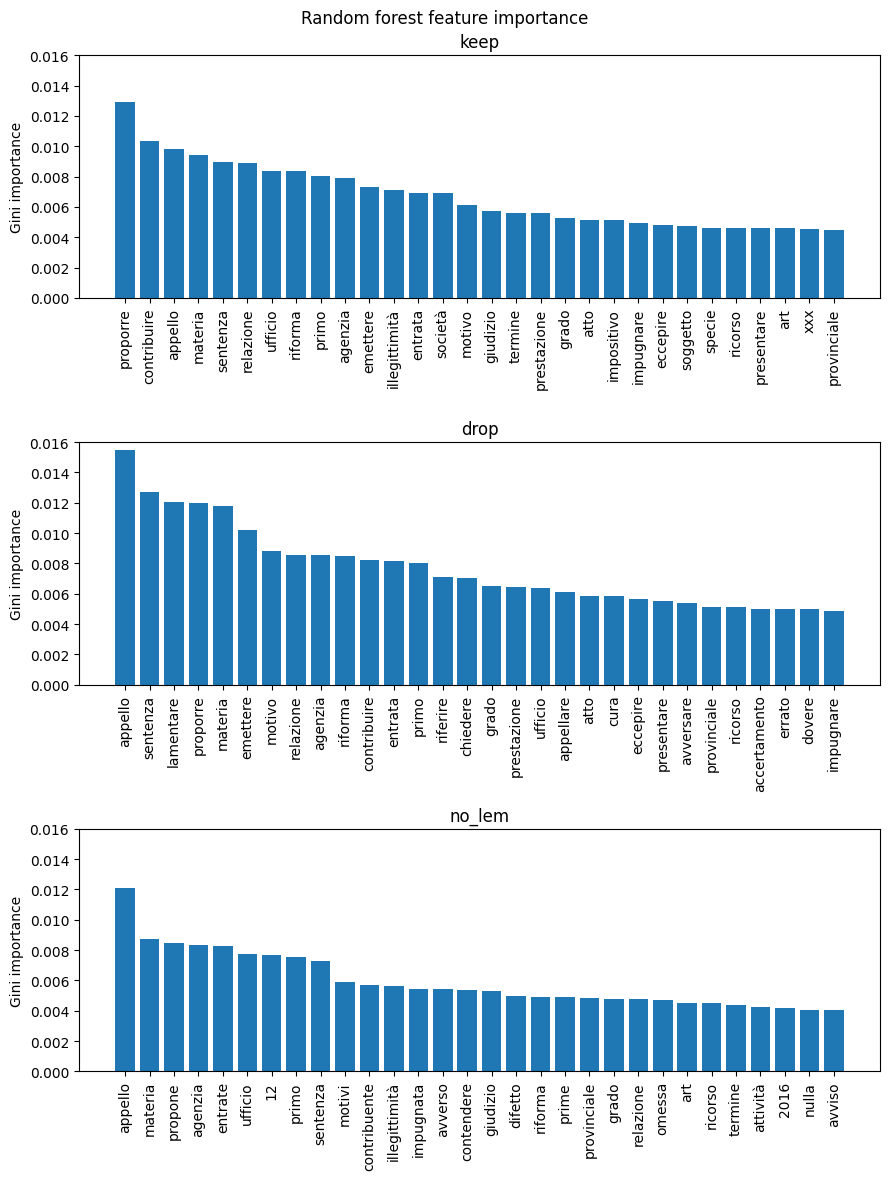

In [21]:
fig, axs = plt.subplots(len(dataframes), 1, figsize=(9, 4 * len(dataframes)))
for (name, df), ax in zip(dataframes, axs):
    random_forest = random_forest.fit(
        *data.count_based_X_y(df, models.DEFAULT_TAGS))
    importances = pd.Series(random_forest[-1].feature_importances_,
                            random_forest[0].get_feature_names_out())

    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('Gini importance')
    ax.title.set_text(name)
    ax.set_autoscaley_on(False)
    ax.set_ybound(0, 0.016)
    ax.bar(*zip(*importances.sort_values(ascending=False)[:30].items()))

plt.suptitle('Random forest feature importance')
plt.tight_layout()
plt.show()

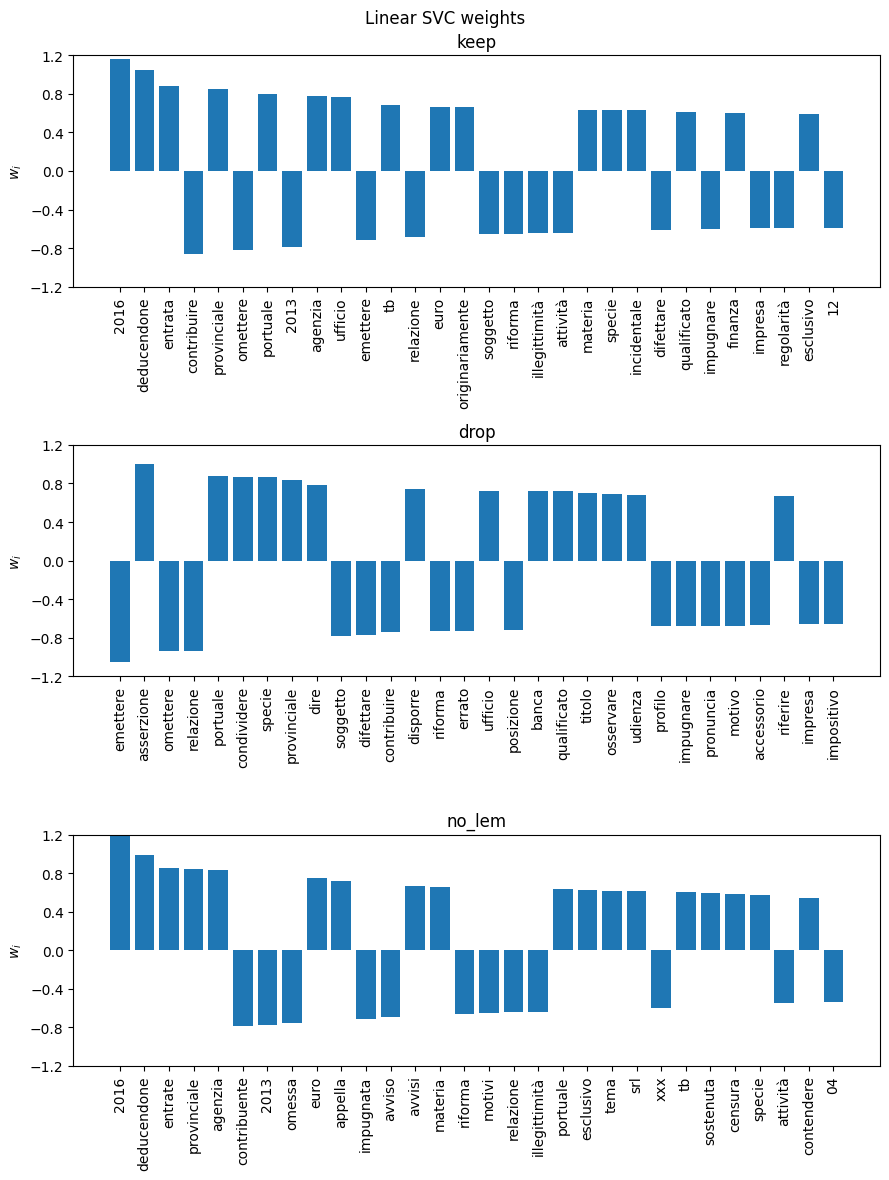

In [20]:
fig, axs = plt.subplots(len(dataframes), 1, figsize=(9, 4 * len(dataframes)))
for (name, df), ax in zip(dataframes, axs):
    linear_svc = linear_svc.fit(*data.count_based_X_y(df,
                                                      models.DEFAULT_TAGS))
    coefficients = pd.Series(linear_svc[-1].coef_[0],
                             linear_svc[0].get_feature_names_out())
    abs_sorted = abs(coefficients).sort_values(ascending=False)[:30]

    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('$w_i$')
    ax.title.set_text(name)
    ax.set_autoscaley_on(False)
    yrange = -1.2, 1.2
    ax.set_yticks(np.arange(*(yrange[0], yrange[1] + 0.4), 0.4))
    ax.set_ybound(*yrange)
    ax.bar(abs_sorted.index, coefficients[abs_sorted.index])

plt.suptitle('Linear SVC weights')
plt.tight_layout()
plt.show()